In [767]:
import re
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
import optuna as opt

Functions

In [768]:
def toLower(x: str) -> str:
    return x.lower()


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x
    
hei = "10:00:00"
print(clockTofloat(hei))

10.0


In [769]:
db = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx")
db

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,NaN
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,NaN
2,L12,Fremst,2022-09-26,09:30:00,Eidsvoll,Nationaltheatret,Ja,Nei,NaN
3,L12,Bakerst,2022-09-26,13:48:00,Nationaltheatret,Eidsvoll,Ja,Nei,NaN
4,R11,Fremst,2022-09-27,06:00:00,Eidsvoll,Oslo Lufthavn,Nei,Ja,NaN
5,R11,Bakerst,2022-09-27,12:13:00,Oslo Lufthavn,Oslo S,Noe,Ja,NaN
6,L12,Bakerst,2022-09-27,14:54:00,Oslo S,Eidsvoll,Ja,Ja,Storkontroll
7,L12,Bakerst,2022-09-28,09:30:00,Eidsvoll,Oslo S,Nei,Nei,NaN
8,L12,Midten,2022-09-28,12:48:00,Nationaltheatret,Eidsvoll,Ja,Nei,NaN
9,R10,Fremst,2022-09-29,07:51:00,Eidsvoll,Nationaltheatret,Ja,Nei,"Sjekket, ble glemt"


In [770]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     44 non-null     object        
 1   Vogn      44 non-null     object        
 2   Dato      44 non-null     datetime64[ns]
 3   Klokke    44 non-null     object        
 4   Fra       44 non-null     object        
 5   Til       44 non-null     object        
 6   Fullt?    44 non-null     object        
 7   Sjekket?  44 non-null     object        
 8   Merknad   3 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 3.2+ KB


Categorizes the easy columns

In [771]:
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Linje"] = pd.Categorical(db["Linje"]).codes
db["Fra"] = pd.Categorical(db["Fra"]).codes
db["Til"] = pd.Categorical(db["Til"]).codes

In [772]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: toLower(x))
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

In [773]:
db.fillna(-1)
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

Sets a time since start instead of date

In [774]:
db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')

In [775]:
db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [776]:
db

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,1,1,0.0,11.30,0,3,1,1,-1
1,3,0,0.0,21.59,2,0,0,0,-1
2,1,1,1.0,9.30,0,2,0,1,-1
3,1,0,1.0,13.48,1,0,0,1,-1
4,4,1,2.0,6.00,0,3,1,0,-1
5,4,0,2.0,12.13,2,4,2,0,-1
6,1,0,2.0,14.54,3,0,0,0,1
7,1,0,3.0,9.30,0,4,1,1,-1
8,0,2,3.0,12.48,1,0,0,1,-1
9,3,1,4.0,7.51,0,2,0,1,0


In [777]:
X = db.drop(["Sjekket?"], axis=1)
y = db["Sjekket?"]

In [778]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [779]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

[14:23:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

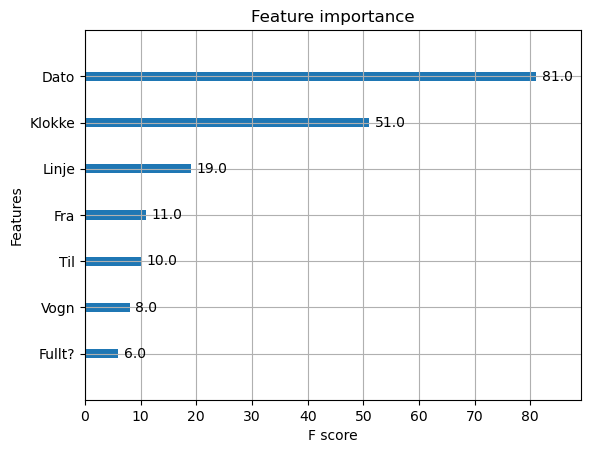

In [780]:
preds = model.predict(X_test)
xgb.plot_importance(model)

In [781]:
X_test

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Merknad
37,2,2,48.0,21.08,4,1,1,-1
24,4,1,27.0,13.00,0,3,1,-1
25,1,0,27.0,20.19,2,0,1,-1
36,4,0,46.0,16.18,1,0,0,-1
34,1,0,41.0,14.19,2,0,1,-1
40,4,1,55.0,11.00,0,3,1,-1
4,4,1,2.0,6.00,0,3,1,-1
12,4,2,5.0,16.18,1,0,0,-1
8,0,2,3.0,12.48,1,0,0,-1


In [784]:
tester = X_test
tester = tester.drop(X_test.index)
testdb = {"Linje": 2, "Vogn": 1, "Dato": 20, "Klokke": 6.00, "Fra": 3, "Til": 1, "Fullt?": 1, "Merknad": -1}
tester = tester.append(testdb, ignore_index=True)

testpred = model.predict(tester)
testpred

/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_10130/4234937933.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tester = tester.append(testdb, ignore_index=True)


array([1], dtype=int8)

In [785]:
db._get_numeric_data

<bound method NDFrame._get_numeric_data of     Linje  Vogn  Dato  Klokke  Fra  Til  Fullt?  Sjekket?  Merknad
0       1     1   0.0   11.30    0    3       1         1       -1
1       3     0   0.0   21.59    2    0       0         0       -1
2       1     1   1.0    9.30    0    2       0         1       -1
3       1     0   1.0   13.48    1    0       0         1       -1
4       4     1   2.0    6.00    0    3       1         0       -1
5       4     0   2.0   12.13    2    4       2         0       -1
6       1     0   2.0   14.54    3    0       0         0        1
7       1     0   3.0    9.30    0    4       1         1       -1
8       0     2   3.0   12.48    1    0       0         1       -1
9       3     1   4.0    7.51    0    2       0         1        0
10      3     0   4.0   11.28    1    0       2         0       -1
11      1     1   5.0   13.30    0    2       0         1       -1
12      4     2   5.0   16.18    1    0       0         1       -1
13      4     1  13